In [1]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
rf.stylely()

In [3]:
ntw = rf.Network('5WL_Plate.s1p')

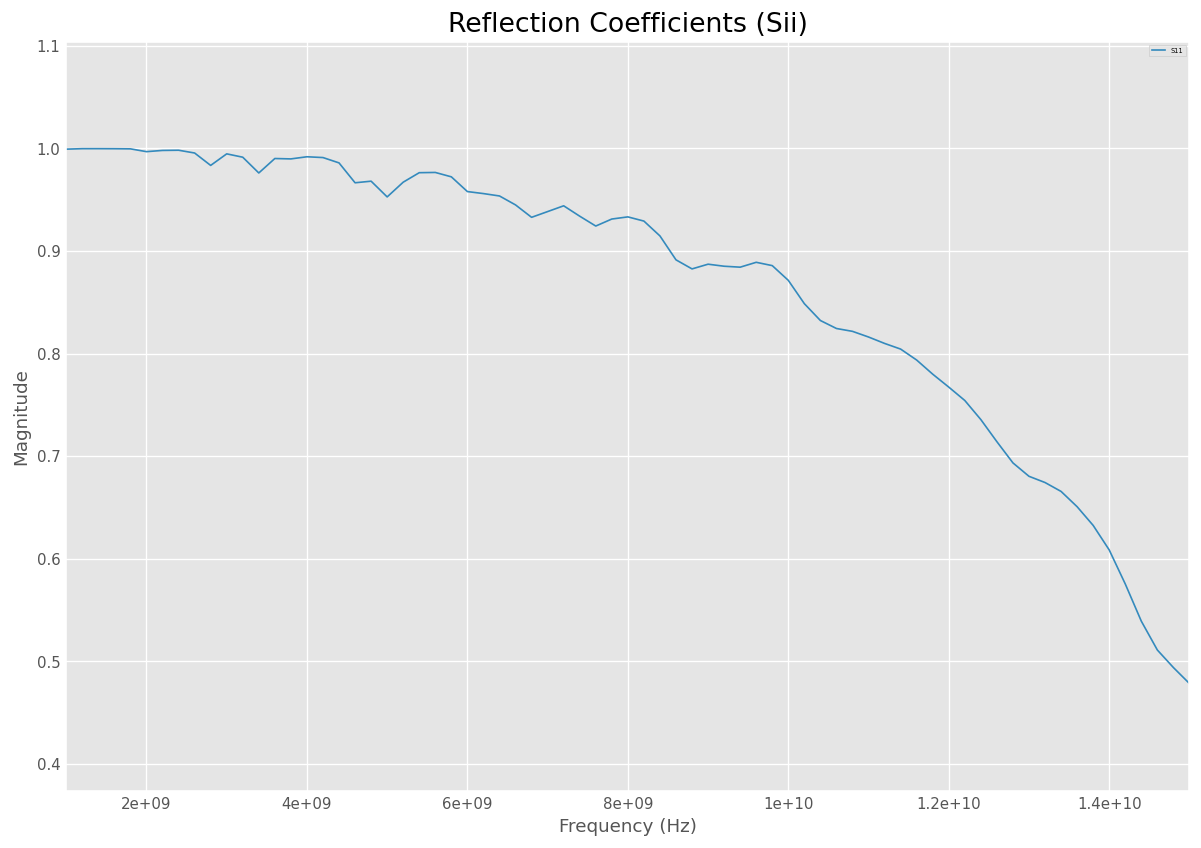

In [185]:
plt.figure(figsize=(12, 8))
for i in range(ntw.number_of_ports):
    ntw.plot_s_mag(m=i, n=i, label=f"S{i+1}{i+1}")
plt.title("Reflection Coefficients (Sii)")
plt.legend(ncol=4, fontsize=4)
#plt.axvline(5020000000)
plt.show()

In [69]:
impedance = ntw.z
z = impedance.flatten()

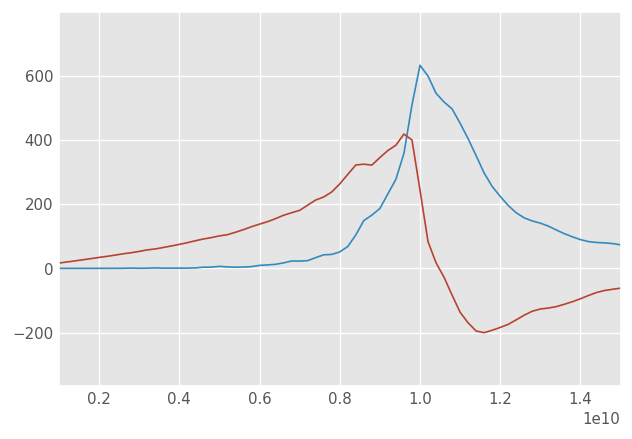

In [39]:
plt.plot(ntw.f, z.real, label='real')
plt.plot(ntw.f, z.imag, label='imag')

In [113]:
ntw.f[5]

2000000000.0

R_S < R_L


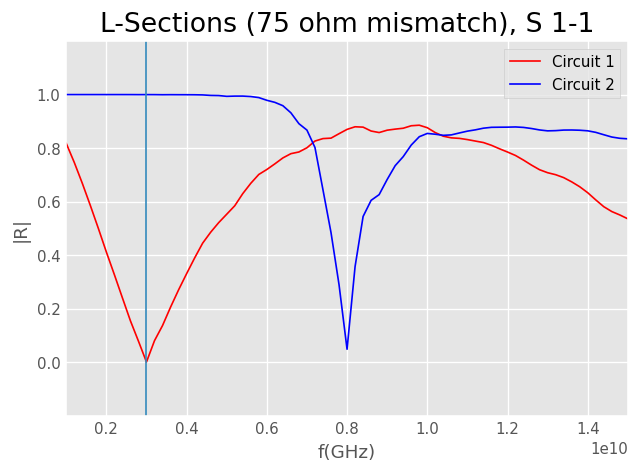

In [167]:
# L Sections

R_L = 50
R_S = z[10].real
X_S = z[10].imag
f = ntw.f[10]
R_mismatch = 50
omega = 2*np.pi*ntw.f

if R_S < R_L:
    Q = np.sqrt(R_L/R_S - 1)
    print('R_S < R_L')
else:
    Q = np.sqrt(R_S/R_L - 1)
    print('R_S > R_L')
        
X_s = Q*R_S
X_p = R_L*Q

L = X_s/(2*np.pi*f)
C = 1/(2*np.pi*f*X_p)

L_imag = np.abs(-X_S/(2*np.pi*f))
C_imag = np.abs(1/(2*np.pi*f*-X_S))
        
circuit1_Z = z + 1/(1j*omega*C_imag) + 1j*omega*L + (1j*omega*C + 1/R_L)**(-1)
circuit2_Z = z + 1/(1j*omega*C_imag) + 1/(1j*omega*C) + (1/(1j*omega*L) + 1/(R_L))**(-1)
circuit3_Z = z + 1j*omega*L_imag + 1j*omega*L + (1j*omega*C + 1/R_L)**(-1)
circuit4_Z = z + 1j*omega*L_imag + 1/(1j*omega*C) + (1/(1j*omega*L) + 1/(R_L))**(-1)

Reflection1 = np.abs((circuit1_Z - R_mismatch)/(circuit1_Z + R_mismatch))
Reflection2 = np.abs((circuit2_Z - R_mismatch)/(circuit2_Z + R_mismatch))
Reflection3 = np.abs((circuit3_Z - R_mismatch)/(circuit3_Z + R_mismatch))
Reflection4 = np.abs((circuit4_Z - R_mismatch)/(circuit4_Z + R_mismatch))

plt.plot(ntw.f, Reflection1, color='r', label='Circuit 1')
plt.plot(ntw.f, Reflection2, color='b', label='Circuit 2')
#plt.plot(ntw.f, Reflection3, color='g', label='Circuit 3')
#plt.plot(ntw.f, Reflection4, color='k', label='Circuit 4')
plt.legend()
plt.axvline(x=f)
plt.ylabel("|R|")
plt.xlabel("f(GHz)")
plt.title(f"L-Sections (75 ohm mismatch), S {i+1}-{i+1}")
plt.show()

In [187]:
L, C, C_imag

(1.9857565219630314e-10, 7.988046494326899e-14, 1.0050182259418349e-12)

In [169]:
def parallel(x, y):
    return (1/x + 1/y)**(-1)
def capacitor(x):
    return 1/(1j*2*np.pi*ntw.f*x)
def inductor(x):
    return 1j*2*np.pi*ntw.f*x

C_i = capacitor(C_imag)
L_i = inductor(L_imag)

3.510035392966112
1.1102864864180528
R_S < R_L
Reflection at 2980000000.00: 0.9989
Reflection at 2980000000.00: 0.9996
Reflection at 2980000000.00: 0.9997
Reflection at 2980000000.00: 0.9995


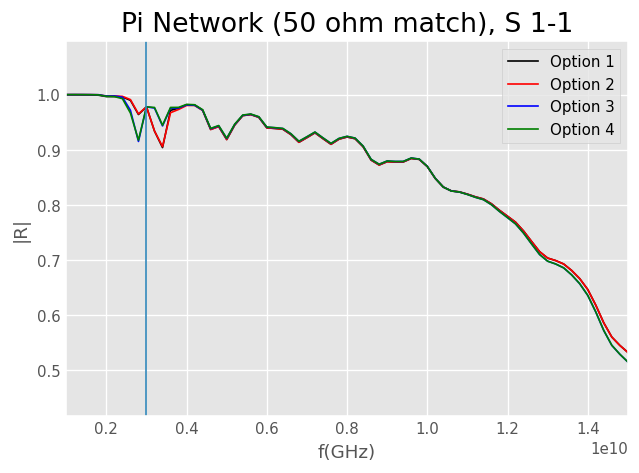

In [181]:
# Pi Networks

R_min = np.sqrt(R_S*R_L)
Q_new = 14

if R_S < R_L:
    Q_min = np.sqrt(R_min/R_S - 1)
    print(Q_min)
    R_H = R_L
    R = R_H/(Q_new**2 + 1)
    R_p2 = R_L
    R_s2 = R
    print(R_S/R)
    Q1 = np.sqrt(R_S/R - 1)
    R_p1 = R_S
    R_s1 = R
    print('R_S < R_L')
else:
    Q_min = np.sqrt(R_S/R_min - 1)
    print(Q_min)
    R_H = R_S
    R = R_H/(Q_new**2 + 1)
    R_p2 = R
    R_s2 = R_S
    print(R_S/R)
    Q1 = np.sqrt(R_L/R - 1)
    R_p1 = R_L
    R_s1 = R
    print('R_S > R_L')


X_p2 = R_p2/Q_new
X_s2 = Q_new*R_s2

X_p1 = R_p1/Q1
X_s1 = Q1*R_s1

# option 1: P1 = cap, S1=ind, S2 = ind, P2 = cap
cap_p1 = 1/(2*np.pi*f*X_p1)
C_p1 = capacitor(cap_p1)
ind_s1 = X_s1/(2*np.pi*f)
L_s1 = inductor(ind_s1)
ind_s2 = X_s2/(2*np.pi*f)
L_s2 = inductor(ind_s2)
cap_p2 = 1/(2*np.pi*f*X_p2)
C_p2 = capacitor(cap_p2)

loop1_1 = parallel(C_p2, R_L)
loop2_1 = loop1_1 + L_s1 + L_s2
loop3_1 = parallel(C_p1, loop2_1) + C_i + z
reflection_opt1 = np.abs((loop3_1 - R_mismatch)/(loop3_1 + R_mismatch))
idx = np.argmin(np.abs(freq - f))
print(f"Reflection at {freq[idx]:.2f}: {reflection_opt1[idx]:.4f}")

# option 2: P1=cap, S1 = ind, S2=cap, P2=ind
cap_s2 = 1/(2*np.pi*f*X_s2)
C_s2 = capacitor(cap_s2)
ind_p2 = X_p2/(2*np.pi*f)
L_p2 = inductor(ind_p2)

loop1_2 = parallel(L_p2, R_L)
loop2_2 = loop1_2 + L_s1 + C_s2
loop3_2 = parallel(C_p1, loop2_2) + C_i + z
reflection_opt2 = np.abs((loop3_2 - R_mismatch)/(loop3_2 + R_mismatch))
print(f"Reflection at {freq[idx]:.2f}: {reflection_opt2[idx]:.4f}")

# option 3: P1=ind, S1=cap, S2=cap, P2=ind
cap_s1 = 1/(2*np.pi*f*X_s1)
C_s1 = capacitor(cap_s1)
ind_p1 = X_p1/(2*np.pi*f)
L_p1 = inductor(ind_p1)

#option 3: L_p1, C_s1, L_p2, C_s2
loop1_3 = parallel(L_p2, R_L)
loop2_3 = loop1_3 + C_s1 + C_s2
loop3_3 = parallel(L_p1, loop2_3) + C_i + z
reflection_opt3 = np.abs((loop3_3 - R_mismatch)/(loop3_3 + R_mismatch))
print(f"Reflection at {freq[idx]:.2f}: {reflection_opt3[idx]:.4f}")

# option 4: P1=ind, S1=cap, S2=ind, P2=cap

loop1_4 = parallel(C_p2, R_L)
loop2_4 = loop1_4 + C_s1 + L_s2
loop3_4 = parallel(L_p1, loop2_4) + C_i + z
reflection_opt4 = np.abs((loop3_4 - R_mismatch)/(loop3_4 + R_mismatch))
print(f"Reflection at {freq[idx]:.2f}: {reflection_opt4[idx]:.4f}")

plt.plot(ntw.f, reflection_opt1, color='k', label='Option 1')
plt.plot(ntw.f, reflection_opt2, color='r', label='Option 2')
plt.plot(ntw.f, reflection_opt3, color='b', label='Option 3')
plt.plot(ntw.f, reflection_opt4, color='g', label='Option 4')
plt.axvline(x=f)
plt.ylabel("|R|")
plt.xlabel("f(GHz)")
plt.title(f"Pi Network (50 ohm match), S {i+1}-{i+1}")
plt.legend(loc="upper right")
plt.show()

R_S < R_L
Reflection at 2980000000.00: 0.9979
Reflection at 2980000000.00: 0.9994
Reflection at 2980000000.00: 0.9997
Reflection at 2980000000.00: 0.9994


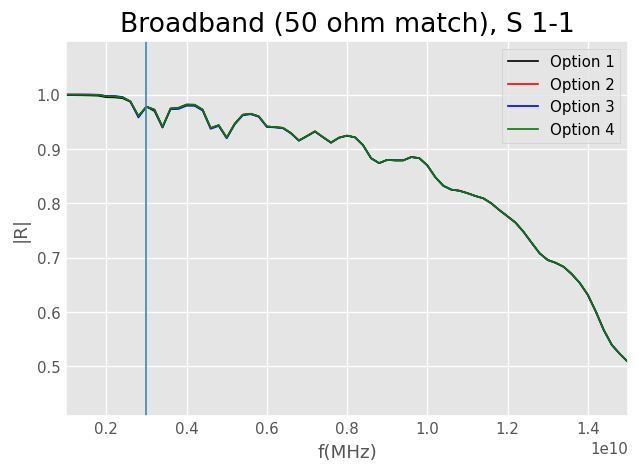

In [183]:
if R_S < R_L:
    print('R_S < R_L')
    Q_wide = Q_min
    R_wide = R_L/(Q_wide**2 + 1)

    R_p1_w = R_wide
    R_s1_w = R_S
    X_p1_w = R_p1_w/Q_wide
    X_s1_w = Q_wide*R_s1_w

    R_p2_w = R_L # shunt resistance
    R_s2_w = R_wide # series resistance (virtual in this instance)
    X_p2_w = R_p2_w/Q_wide
    X_s2_w = Q_wide*R_s2_w

    cap_p1_w = 1/(2*np.pi*f*X_p1_w)
    C_p1_w = capacitor(cap_p1_w) # ohms
    ind_p1_w = X_p1_w/(2*np.pi*f)
    L_p1_w = inductor(ind_p1_w) # ohms

    cap_s1_w = 1/(2*np.pi*f*X_s1_w)
    C_s1_w = capacitor(cap_s1_w) # ohms
    ind_s1_w = X_s1_w/(2*np.pi*f)
    L_s1_w = inductor(ind_s1_w) # ohms

    cap_p2_w = 1/(2*np.pi*f*X_p2_w)
    C_p2_w = capacitor(cap_p2_w) # ohms
    ind_p2_w = X_p2_w/(2*np.pi*f)
    L_p2_w = inductor(ind_p2_w) # ohms

    cap_s2_w = 1/(2*np.pi*f*X_s2_w)
    C_s2_w = capacitor(cap_s2_w) # ohms
    ind_s2_w = X_s2_w/(2*np.pi*f)
    L_s2_w = inductor(ind_s2_w) # ohms

    #option 1: C_p1, L_s1, C_p2, L_s2
    loop1_1_w = parallel(C_p2_w, R_L)
    loop2_1_w = loop1_1_w + L_s2_w
    loop3_1_w = parallel(C_p1_w, loop2_1_w)
    loop4_1_w = loop3_1_w + L_s1_w + C_i + z
    reflection_opt1_w = np.abs(((loop4_1_w - R_mismatch)/(loop4_1_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt1_w[idx]:.4f}")

    #option 2: C_p1, L_s1, L_p2, C_s2
    loop1_2_w = parallel(L_p2_w, R_L)
    loop2_2_w = loop1_2_w + C_s2_w
    loop3_2_w = parallel(C_p1_w, loop2_2_w)
    loop4_2_w = loop3_2_w + L_s1_w + C_i + z
    reflection_opt2_w = np.abs(((loop4_2_w - R_mismatch)/(loop4_2_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt2_w[idx]:.4f}")

    #option 3: L_p1, C_s1, L_p2, C_s2
    loop1_3_w = parallel(L_p2_w, R_L)
    loop2_3_w = loop1_3_w + C_s2_w
    loop3_3_w = parallel(L_p1_w, loop2_3_w)
    loop4_3_w = loop3_3_w + C_s1_w + C_i + z
    reflection_opt3_w = np.abs(((loop4_3_w - R_mismatch)/(loop4_3_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt3_w[idx]:.4f}")

    #option 4: L_p1, C_s1, C_p2, L_s2
    loop1_4_w = parallel(C_p2_w, R_L)
    loop2_4_w = loop1_4_w + L_s2_w
    loop3_4_w = parallel(L_p1_w, loop2_4_w)
    loop4_4_w = loop3_4_w + C_s1_w + C_i + z
    reflection_opt4_w = np.abs(((loop4_4_w - R_mismatch)/(loop4_4_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt4_w[idx]:.4f}")

else:
    print('R_S > R_L')
    Q_wide = Q_min
    R_wide = R_S/(Q_wide**2 + 1)

    R_p1_w = R_wide
    R_s1_w = R_S
    X_p1_w = R_p1_w/Q_wide
    X_s1_w = Q_wide*R_s1_w

    R_p2_w = R_L # shunt resistance
    R_s2_w = R_wide # series resistance (virtual in this instance)
    X_p2_w = R_p2_w/Q_wide
    X_s2_w = Q_wide*R_s2_w

    cap_p1_w = 1/(2*np.pi*f*X_p1_w)
    C_p1_w = capacitor(cap_p1_w) # ohms
    ind_p1_w = X_p1_w/(2*np.pi*f)
    L_p1_w = inductor(ind_p1_w) # ohms

    cap_s1_w = 1/(2*np.pi*f*X_s1_w)
    C_s1_w = capacitor(cap_s1_w) # ohms
    ind_s1_w = X_s1_w/(2*np.pi*f)
    L_s1_w = inductor(ind_s1_w) # ohms

    cap_p2_w = 1/(2*np.pi*f*X_p2_w)
    C_p2_w = capacitor(cap_p2_w) # ohms
    ind_p2_w = X_p2_w/(2*np.pi*f)
    L_p2_w = inductor(ind_p2_w) # ohms

    cap_s2_w = 1/(2*np.pi*f*X_s2_w)
    C_s2_w = capacitor(cap_s2_w) # ohms
    ind_s2_w = X_s2_w/(2*np.pi*f)
    L_s2_w = inductor(ind_s2_w) # ohms

    #option 1: C_p1, L_s1, C_p2, L_s2
    series_1 = R_L + L_s2_w
    loop1_1_w = parallel(C_p2_w, series_1)
    loop2_1_w = loop1_1_w + L_s1_w
    loop3_1_w = parallel(C_p1_w, loop2_1_w)
    loop4_1_w = loop3_1_w + C_i + z
    reflection_opt1_w = np.abs(((loop4_1_w - R_mismatch)/(loop4_1_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt1_w[idx]:.4f}")

    #option 2: C_p1, L_s1, L_p2, C_s2
    series_2 = R_L + C_s2_w
    loop1_2_w = parallel(L_p2_w, series_2)
    loop2_2_w = loop1_2_w + L_s1_w
    loop3_2_w = parallel(C_p1_w, loop2_2_w)
    loop4_2_w = loop3_2_w + C_i + z
    reflection_opt2_w = np.abs(((loop4_2_w - R_mismatch)/(loop4_2_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt2_w[idx]:.4f}")

    #option 3: L_p1, C_s1, L_p2, C_s2
    series_3 = R_L + C_s2_w
    loop1_3_w = parallel(L_p2_w, series_3)
    loop2_3_w = loop1_3_w + C_s1_w
    loop3_3_w = parallel(L_p1_w, loop2_3_w)
    loop4_3_w = loop3_3_w + C_i + z
    reflection_opt3_w = np.abs(((loop4_3_w - R_mismatch)/(loop4_3_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt3_w[idx]:.4f}")

    #option 4: L_p1, C_s1, C_p2, L_s2
    series_4 = R_L + L_s2_w
    loop1_4_w = parallel(C_p2_w, series_4)
    loop2_4_w = loop1_4_w + C_s1_w
    loop3_4_w = parallel(L_p1_w, loop2_4_w)
    loop4_4_w = loop3_4_w + C_i + z
    reflection_opt4_w = np.abs(((loop4_4_w - R_mismatch)/(loop4_4_w + R_mismatch)))
    print(f"Reflection at {freq[idx]:.2f}: {reflection_opt4_w[idx]:.4f}")

plt.plot(ntw.f, reflection_opt1_w, color='k', label='Option 1')
plt.plot(ntw.f, reflection_opt2_w, color='r', label='Option 2')
plt.plot(ntw.f, reflection_opt3_w, color='b', label='Option 3')
plt.plot(ntw.f, reflection_opt4_w, color='g', label='Option 4')
plt.axvline(x=f)
plt.ylabel("|R|")
plt.xlabel("f(MHz)")
plt.title(f"Broadband (50 ohm match), S {i+1}-{i+1}")
plt.legend(loc="upper right")
plt.show()